In [18]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import numpyro

/home/wilkgpu/envs/numpyro/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/home/wilkgpu/envs/numpyro/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import arviz as az

from tabulate import tabulate
import numpy as np
from collections import OrderedDict
from itertools import cycle

In [ ]:
palette = cycle(sns.color_palette())
color_m = next(palette)
color_f = next(palette)

In [ ]:
import sentencepiece 
spm = sentencepiece.SentencePieceProcessor('data/en-tr.bpe.model')

In [ ]:
import json
import gzip

def read_json(fn):
    if fn.endswith('.gz'):
        with gzip.open(fn, 'rt', encoding='UTF-8') as f:
            return json.load(f) 
    else:        
        with open(fn, 'r') as f:
            return json.load(f)

In [ ]:
exp_dict = read_json('experiments-data/en-tr.100as.100ns.wmt2017-test.json.gz')
S = 1

length_as = [np.random.permutation([len(spm.tokenize(samp['sample'])) for samp in job['MC']]) for job in exp_dict['data']]
length_as = np.array(length_as)[:,:S]

length_ns = [np.random.permutation([len(spm.tokenize(cand['hypothesis'])) for cand in job['candidates']]) for job in exp_dict['data']]
length_ns = np.array(length_ns)[:,:S]

length_ref = [len(spm.tokenize(job['ref'])) for job in exp_dict['data']]
length_ref = np.array(length_ref)
length_ref.shape

length_as.shape, length_ns.shape, length_ref.shape

((3007, 1), (3007, 1), (3007,))

In [ ]:
exp_dict = read_json('experiments-data/en-tr.100as.5bs.wmt2017-test.json.gz')

length_bs = [[len(spm.tokenize(cand['hypothesis'])) for cand in job['candidates']]for job in exp_dict['data']]
length_bs = np.array(length_bs)[:,:S]

length_bs.shape

(3007, 1)

In [ ]:
group_names = ['REF', 'AS', 'NS', 'BS']
all_data = [length_ref, length_as, length_ns, length_bs]

In [ ]:
headers = ['Stats'] + group_names
rows = [
    ['size'] + [np.size(obs) for obs in all_data],
    ['mean'] + [np.mean(obs) for obs in all_data],
    ['std'] + [np.std(obs) for obs in all_data],
    ['median'] + [np.median(obs) for obs in all_data],
    ['min'] + [np.min(obs) for obs in all_data],
    ['max'] + [np.max(obs) for obs in all_data],
]
print(tabulate(rows, headers=headers, floatfmt='.2f'))

Stats        REF       AS       NS       BS
-------  -------  -------  -------  -------
size     3007.00  3007.00  3007.00  3007.00
mean       27.01    27.25    25.86    25.99
std        16.14    15.95    14.92    15.15
median     24.00    24.00    23.00    23.00
min         3.00     3.00     3.00     3.00
max       321.00   198.00   200.00   199.00


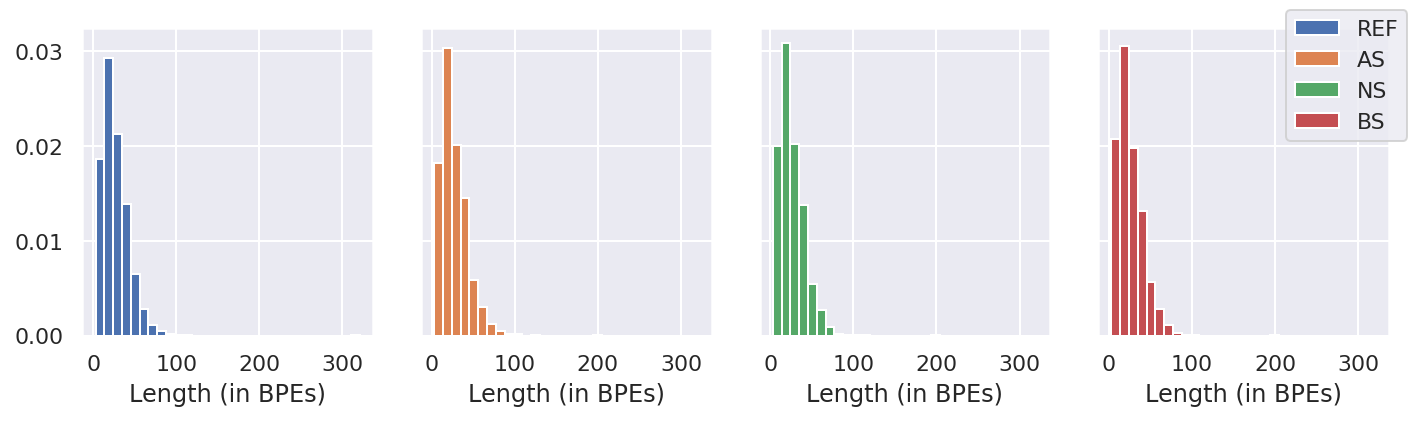

In [ ]:
fig, ax = plt.subplots(1, len(all_data), sharex=True, sharey=True, figsize=(10, 3))
bins = np.histogram_bin_edges(np.concatenate([obs.flatten() for obs in all_data]), bins=30)
palette = cycle(sns.color_palette())
for g in range(len(all_data)):
    ax[g].hist(all_data[g].flatten(), bins=bins, color=next(palette), label=group_names[g], density=True)
    ax[g].set_xlabel('Length (in BPEs)')
fig.tight_layout(h_pad=2, w_pad=2)
_ = fig.legend()

In [ ]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp
import jax
from numpyro.contrib.indexing import Vindex

NUM_CHAINS = 1
numpyro.set_host_device_count(NUM_CHAINS)
print(f"Running on NumPryo v{numpyro.__version__}")

Running on NumPryo v0.8.0


In [ ]:
class DPMixture:
    def __init__(self, group_names: list, observations: list, 
                 gamma_shape=[1., 1.], DP_alpha=1., num_comps=5,
                 num_samples=1000, num_chains=1, num_warmup=100):

        self.gamma_shape = gamma_shape
        self.DP_alpha = DP_alpha
        self.T = num_comps

        self.group_names = group_names
        self.G = len(group_names)
        
        self.N = sum(len(y) for y in observations)
        # [N]
        self.x = np.concatenate([[g] * len(y) for g, y in enumerate(observations)])
        self.y = np.concatenate(observations)

        self.num_samples = num_samples
        self.num_chains = num_chains
        self.num_warmup = num_warmup

        self.rng_key = random.PRNGKey(0)

        nuts_kernel = NUTS(self.model)
        self.mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains)

        self.prior_predictive = None
        self.posterior_predictive = None
        self.posterior_samples = None

    @classmethod
    def mix_weights(cls, beta):
        beta1m_cumprod = (1 - beta).cumprod(-1)
        return jnp.pad(beta, ((0, 0), (0, 1)), constant_values=1) * jnp.pad(beta1m_cumprod, ((0, 0), (1, 0)), constant_values=1)
    
    @classmethod
    def mix_weights1d(cls, beta):
        beta1m_cumprod = (1 - beta).cumprod(-1)
        return jnp.pad(beta, ((0, 1),), constant_values=1) * jnp.pad(beta1m_cumprod, ((1, 0),), constant_values=1)

    def model(self, y=None):
        """
        Pyro joint distribution.
        
        Parameter:
        
        y: observations as returned by self.prepare or None. 
            If None, the 'obs' node of the graphical model will be resampled.
        """

        N, G = self.N, self.G
        T = self.T

        with numpyro.plate("components", T):  
            # construct the components
            # [T]
            lamb = numpyro.sample("lambda", dist.Gamma(self.gamma_shape[0], self.gamma_shape[1]))   
            rate = numpyro.deterministic("rate", jnp.cumsum(lamb))  # we could use jnp.sort, but cumsum is simpler 

        if G > 1:
            # Sample mixing weights    
            with numpyro.plate("DPs", G):
                # [G, T-1]
                beta = numpyro.sample(
                    "beta", 
                    dist.Beta(
                        np.ones(1), 
                        np.ones(1) * self.DP_alpha
                    ).expand((T-1,)).to_event(1)
                )
            # [G, T]
            omega = numpyro.deterministic("omega", self.mix_weights(beta))
            # [N, T]
            omega_x = numpyro.deterministic("omega_x", omega[self.x])
        elif G == 1:            
            # [T-1]
            beta = numpyro.sample(
                "beta", 
                dist.Beta(
                    np.ones(1), 
                    np.ones(1) * self.DP_alpha
                ).expand((T-1,)).to_event(1)
            )
            # [T]
            omega = numpyro.deterministic("omega", self.mix_weights1d(beta))
            # [N, T]
            omega_x = Vindex(jnp.expand_dims(omega, -2))[jnp.zeros_like(self.x)]
        else:
            raise ValueError("I need at least 1 group")
        
        with numpyro.plate("observations", N):            
            # [N]            
            z = numpyro.sample("z", dist.Categorical(probs=omega_x)) 

            # [N]
            # To avoid confusion, I'm no longer creating a deterministic size for rate_z
            #  rate_z = numpyro.deterministic("rate_z", rate[z])
            rate_z = rate[z]
            # [N]
            # Construct the likelihood function            
            return numpyro.sample("y", dist.Poisson(rate_z), obs=y)

    def run(self):
        self.mcmc.run(self.rng_key, y=self.y)
        self.mcmc.print_summary()
        self.posterior_samples = self.mcmc.get_samples(group_by_chain=False)
        print("posterior samples shapes:")
        for k, v in self.posterior_samples.items():
            print(k, v.shape)

    def make_prior_predictive(self, num_prior_samples=100):        
        if self.prior_predictive is None:
            self.prior_predictive = Predictive(self.model, num_samples=num_prior_samples)

    def draw_prior_predictions(self):
        if self.prior_predictive is None:
            self.make_prior_predictive()
        rng_key, rng_key_ = random.split(self.rng_key) 
        return self.prior_predictive(rng_key_, y=None)

    def make_posterior_predictive(self):
        if self.posterior_samples is None:
            raise RuntimeError("You need to run the sampler first")        
        if self.posterior_predictive is None:
            self.posterior_predictive = Predictive(self.model, self.posterior_samples, infer_discrete=False)        

    def draw_posterior_predictions(self, plot=False):
        if self.posterior_predictive is None:
            self.make_posterior_predictive()        
        rng_key, rng_key_ = random.split(self.rng_key)
        return self.posterior_predictive(rng_key_, y=None)
    
    @classmethod
    def _select_local_rates(cls, rates, z):
        """
        rates [num_samples, num_components]: these are positive scalars
        z [num_samples, data_size]: these are integers in [0, num_components)
        output: [num_samples, data_size] positive scalars
            which are the rates selected by z for each data point

        z should come from Predictive with infer_discrete=True and conditioned on observations
        """
        T = model.T
        return (jax.nn.one_hot(z, T) *  jnp.expand_dims(rates, -2)).sum(-1)

    def infer_local_assignments(self, posterior_samples, y):
        """
        Annotate y with z given posterior samples and y.
        
        Common use: infer_local_assignments(model.posterior_samples, model.y)
        
        Return: dictionary with local assignments
            * z: [num_samples, data_size]
            * rate_z: [num_samples, data_size]
        """
        if self.posterior_samples is None:
            raise ValueError("I need posterior samples that are paired with y samples (or observations)")
            posterior_samples = model.posterior_samples
        if y is None:
            raise ValueError("I need y samples (or observations) that are paired with posterior samples")
        
        rng_key, rng_key_ = random.split(self.rng_key)
        predictive = Predictive(self.model, posterior_samples, infer_discrete=True)
        discrete_samples = predictive(rng_key_, y=y)
        z = discrete_samples['z']
        rates_z = self._select_local_rates(posterior_samples['rate'], z)
        return {'z': z, 'rate_z': rates_z}

In [ ]:
def plot_predictions(model, samples, bins=[20, 100], density=[True, True], sharex=True, sharey=True):
    fig, ax = plt.subplots(model.G, 2, sharex=sharex, sharey=sharey, figsize=(10, 5))
    if model.G == 1:
        ax = ax.reshape(1, -1)
    pal = cycle(sns.color_palette())
    for k in range(model.G):
        
        yk = model.y[model.x==k]
        yk_ = samples[:,model.x==k]
        c = next(pal)
        _ = ax[k, 0].hist(yk, bins=bins[0], color=c, density=density[0])
        _ = ax[k, 0].set_xlabel(f'obs: {model.group_names[k]}')
        _ = ax[k, 1].hist(yk_.flatten(), bins=bins[1], color=c, density=density[1])
        _ = ax[k, 1].set_xlabel(f'predictive: {model.group_names[k]}')

    fig.tight_layout(h_pad=2, w_pad=2)
    fig.show()

def plot_checks(model, samples, bins=30):
    fig, ax = plt.subplots(model.G, 4, sharex=False, figsize=(15, 5))
    if model.G == 1:
        ax = ax.reshape(1, -1)
    pal = cycle(sns.color_palette())
    for k in range(model.G):
        c = next(pal)
        yk = model.y[model.x==k]
        yk_ = samples[:,model.x==k]
        
        _ = ax[k, 0].hist(np.mean(yk_, 1), bins=bins, color=c, label='pred' if k == 0 else None)
        _ = ax[k, 0].axvline(np.mean(yk), color='black', linestyle='--', label='obs' if k == 0 else None)    
        _ = ax[k, 0].set_xlabel(f'E[Y{k}]')
        
        _ = ax[k, 1].hist(np.std(yk_, 1), color=c, bins=bins)    
        _ = ax[k, 1].axvline(np.std(yk), color='black', linestyle='--')
        _ = ax[k, 1].set_xlabel(f'std[Y{k}]')

        _ = ax[k, 2].hist(np.median(yk_, 1), color=c, bins=bins)    
        _ = ax[k, 2].axvline(np.median(yk), color='black', linestyle='--')
        _ = ax[k, 2].set_xlabel(f'median[Y{k}]')

        pvalues = np.mean(yk_ > yk, 1)
        _ = ax[k, 3].hist(pvalues, bins=bins)
        _ = ax[k, 3].set_xlabel(f'Pr(Y{k} > obs{k})')
        _ = ax[k, 3].axvline(np.median(pvalues), color='black', linestyle=':', label='median' if k==0 else None)

    _ = fig.legend(loc='upper center', ncol=3)
    fig.tight_layout(h_pad=2, w_pad=2)
    fig.show()

In [ ]:
model = DPMixture(
    group_names[:1], #group_names
    [all_data[0].flatten()], #[obs.flatten() for obs in all_data], 
    gamma_shape=[1., 0.1], 
    num_comps=5,
    DP_alpha=0.1, 
    num_chains=NUM_CHAINS, num_warmup=500, num_samples=2000)

In [ ]:
with numpyro.handlers.seed(rng_seed=1):
    trace = numpyro.handlers.trace(model.model).get_trace(y=None)
print(numpyro.util.format_shapes(trace))

     Trace Shapes:         
      Param Sites:         
     Sample Sites:         
  components plate    5 |  
       lambda dist    5 |  
             value    5 |  
         beta dist      | 4
             value      | 4
observations plate 3007 |  
            z dist 3007 |  
             value 3007 |  
            y dist 3007 |  
             value 3007 |  


In [ ]:
with numpyro.handlers.seed(rng_seed=1):
    trace = numpyro.handlers.trace(model.model).get_trace(y=model.y)
print(numpyro.util.format_shapes(trace))

     Trace Shapes:         
      Param Sites:         
     Sample Sites:         
  components plate    5 |  
       lambda dist    5 |  
             value    5 |  
         beta dist      | 4
             value      | 4
observations plate 3007 |  
            z dist 3007 |  
             value 3007 |  
            y dist 3007 |  
             value 3007 |  


In [ ]:
prior_samples = model.draw_prior_predictions()

In [ ]:
print(tabulate([(k, v.shape) for k, v in prior_samples.items()], headers=['rv', 'shape']))

rv      shape
------  -----------
beta    (100, 4)
lambda  (100, 5)
omega   (100, 5)
rate    (100, 5)
y       (100, 3007)
z       (100, 3007)


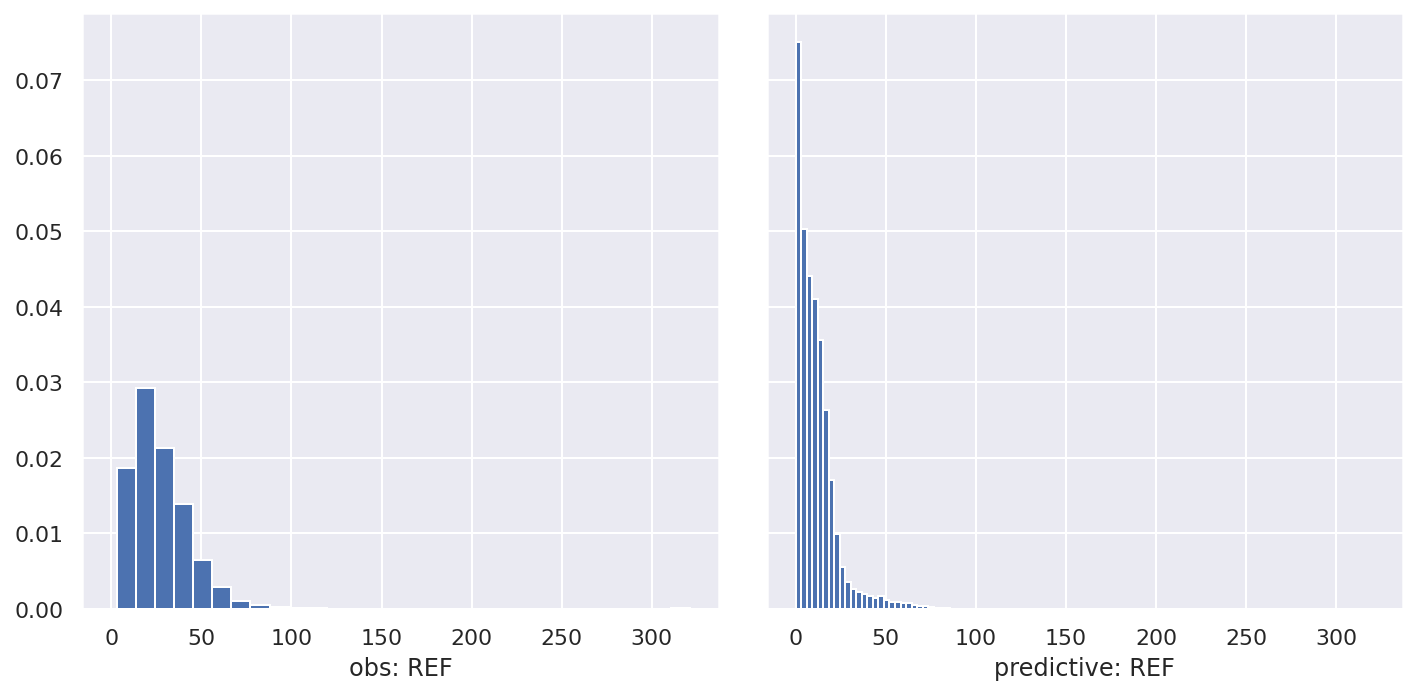

In [ ]:
_ = plot_predictions(model, prior_samples['y'], sharex='row', bins=[30, 30])

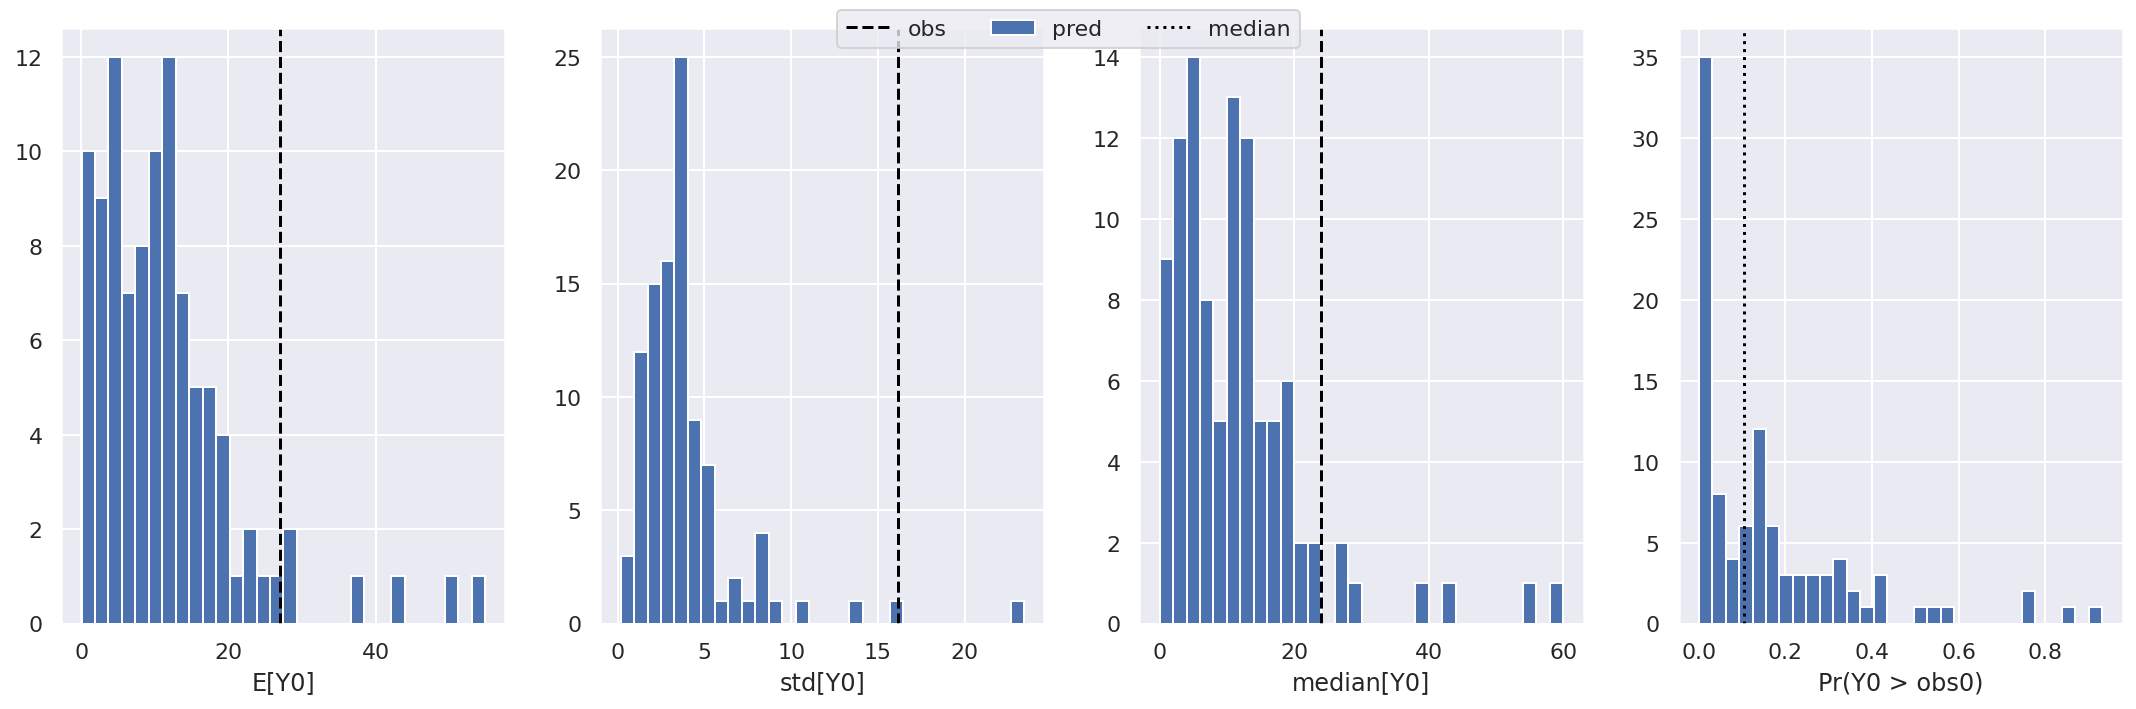

In [ ]:
_ = plot_checks(model, prior_samples['y'])

In [ ]:
model.run()

sample: 100%|██████████| 2500/2500 [00:10<00:00, 238.59it/s, 7 steps of size 4.84e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.30      0.01      0.30      0.28      0.32   1250.96      1.00
   beta[1]      0.56      0.02      0.56      0.53      0.59   1334.02      1.00
   beta[2]      0.84      0.02      0.84      0.81      0.87   1942.85      1.00
   beta[3]      0.99      0.01      0.99      0.98      1.00   2300.72      1.00
 lambda[0]     11.80      0.20     11.80     11.49     12.15   1305.89      1.00
 lambda[1]     12.47      0.33     12.47     11.97     13.07   1097.27      1.00
 lambda[2]     16.52      0.42     16.51     15.83     17.19   1680.91      1.00
 lambda[3]     25.99      1.01     25.98     24.41     27.73   1835.35      1.00
 lambda[4]    225.77     16.44    225.93    198.51    251.66   2644.86      1.00

Number of divergences: 0
posterior samples shapes:
beta (2000, 4)
lambda (2000, 5)
omega (2000, 5)
rate (2000, 5)


In [ ]:
posterior_samples = model.draw_posterior_predictions()

In [ ]:
print(tabulate([(k, v.shape) for k, v in posterior_samples.items()], headers=['rv', 'shape']))

rv     shape
-----  ------------
omega  (2000, 5)
rate   (2000, 5)
y      (2000, 3007)
z      (2000, 3007)


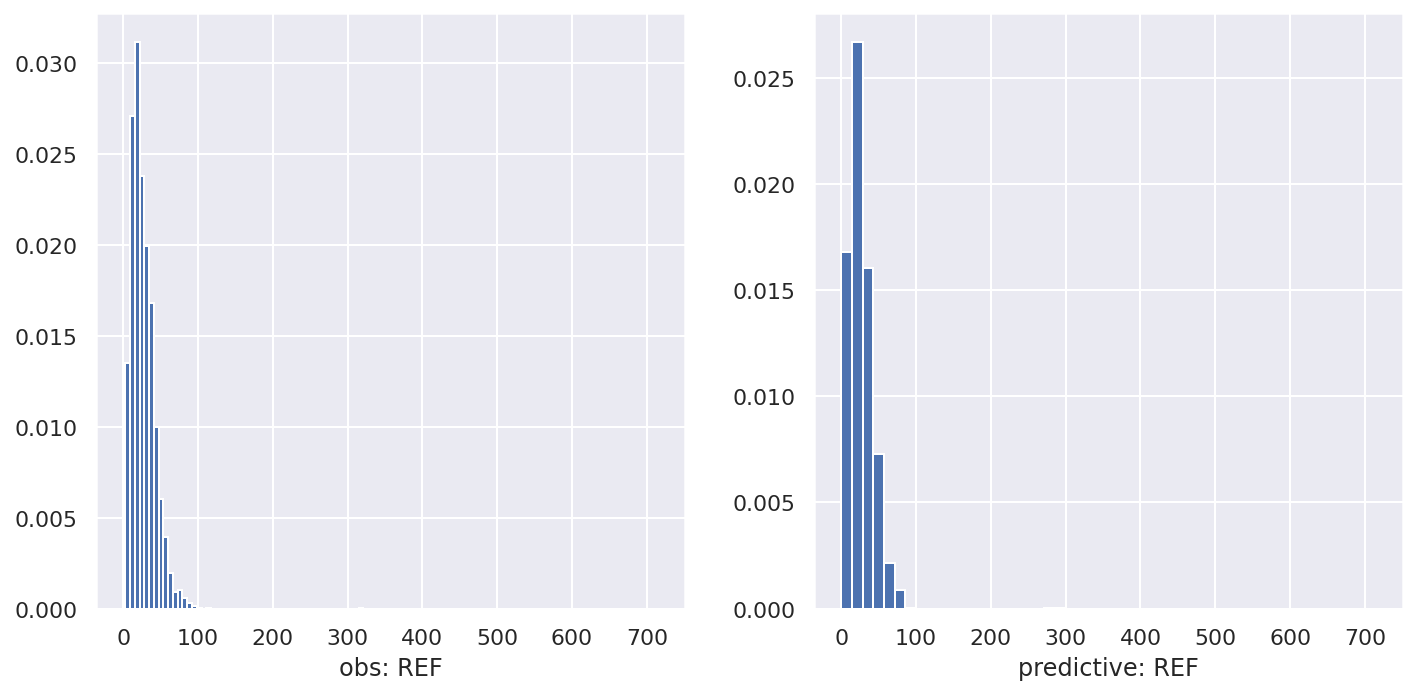

In [ ]:
_ = plot_predictions(model, posterior_samples['y'], bins=[50, 50], sharex='row', sharey='col')

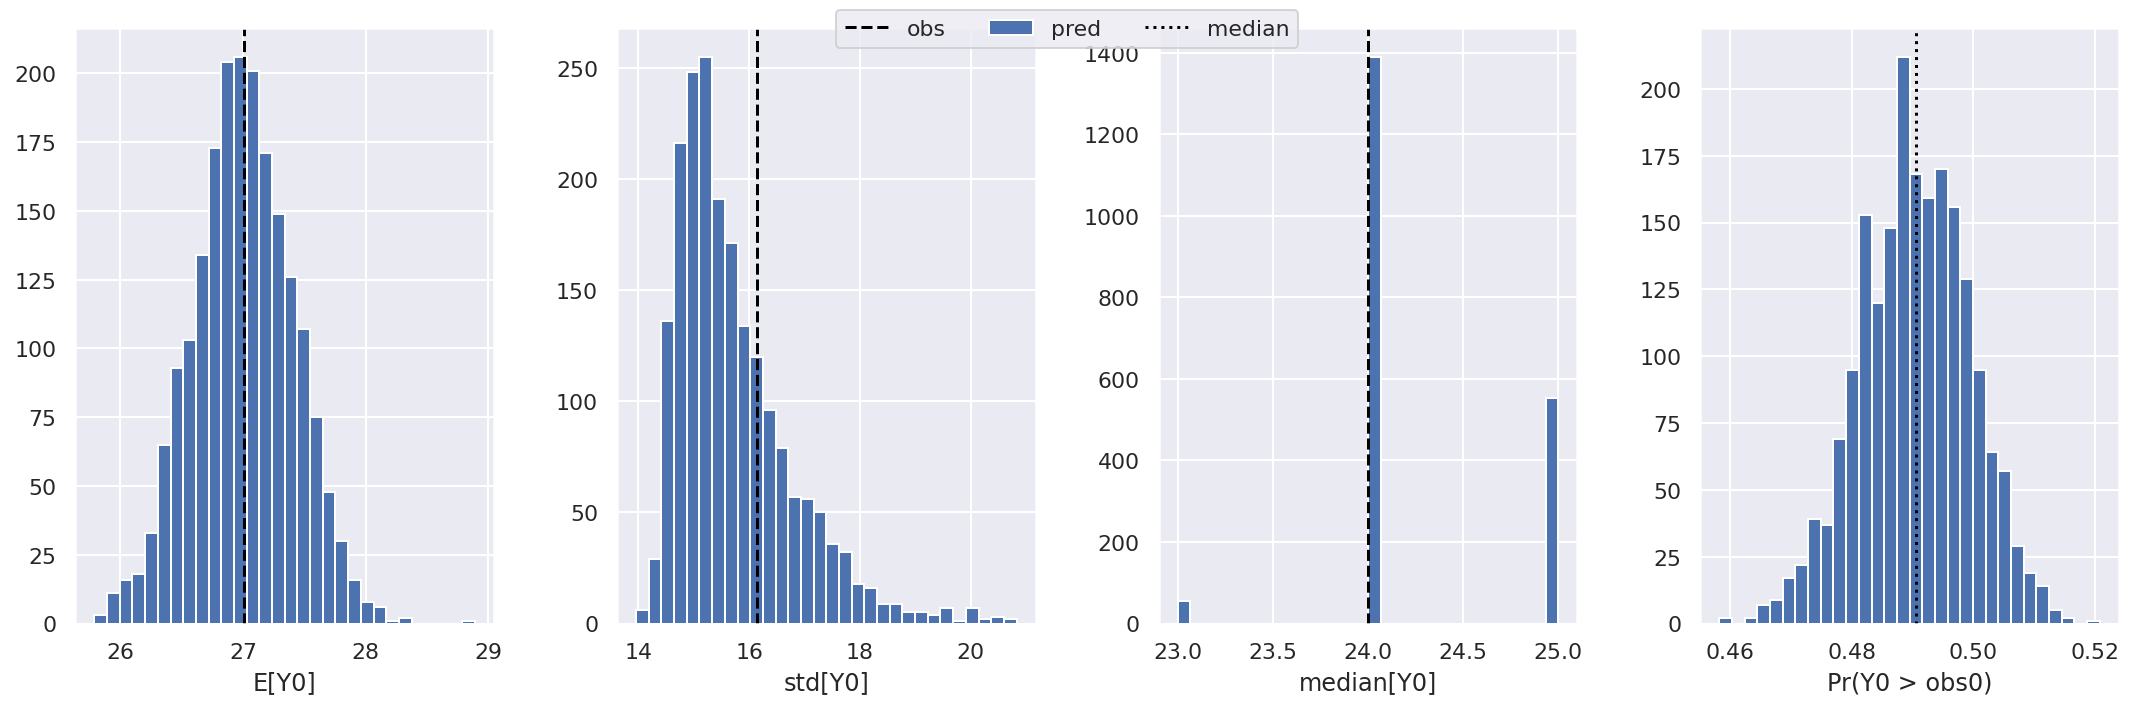

In [ ]:
_ = plot_checks(model, posterior_samples['y'])

In [ ]:
local_samples = model.infer_local_assignments(model.posterior_samples, model.y)

In [ ]:
print(tabulate([(k, v.shape) for k, v in local_samples.items()], headers=['rv', 'shape']))

rv      shape
------  ------------
z       (2000, 3007)
rate_z  (2000, 3007)


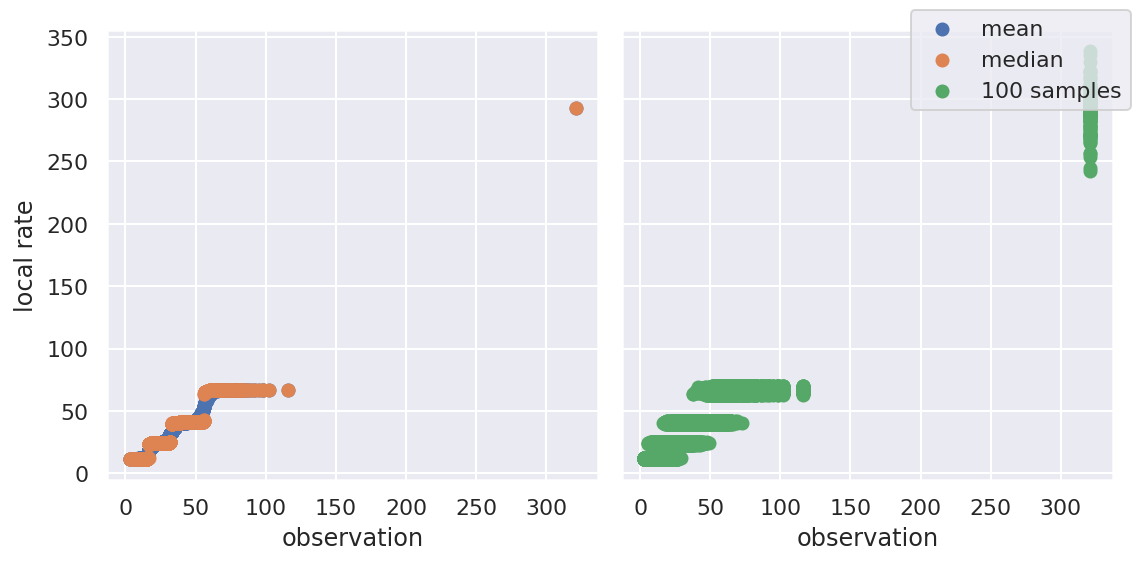

In [ ]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
pal = cycle(sns.color_palette())
_ = ax[0].scatter(model.y, np.mean(local_samples['rate_z'], 0), color=next(pal), label='mean')
_ = ax[0].scatter(model.y, np.median(local_samples['rate_z'], 0), color=next(pal), label='median')
_ = ax[1].scatter(jnp.repeat(model.y[None,:], 100, 0).flatten(), local_samples['rate_z'][:100,:].flatten(), color=next(pal), label='100 samples')
_ = ax[0].set_xlabel('observation')
_ = ax[0].set_ylabel('local rate')
_ = ax[1].set_xlabel('observation')
fig.tight_layout(h_pad=1, w_pad=1)
_ = fig.legend()

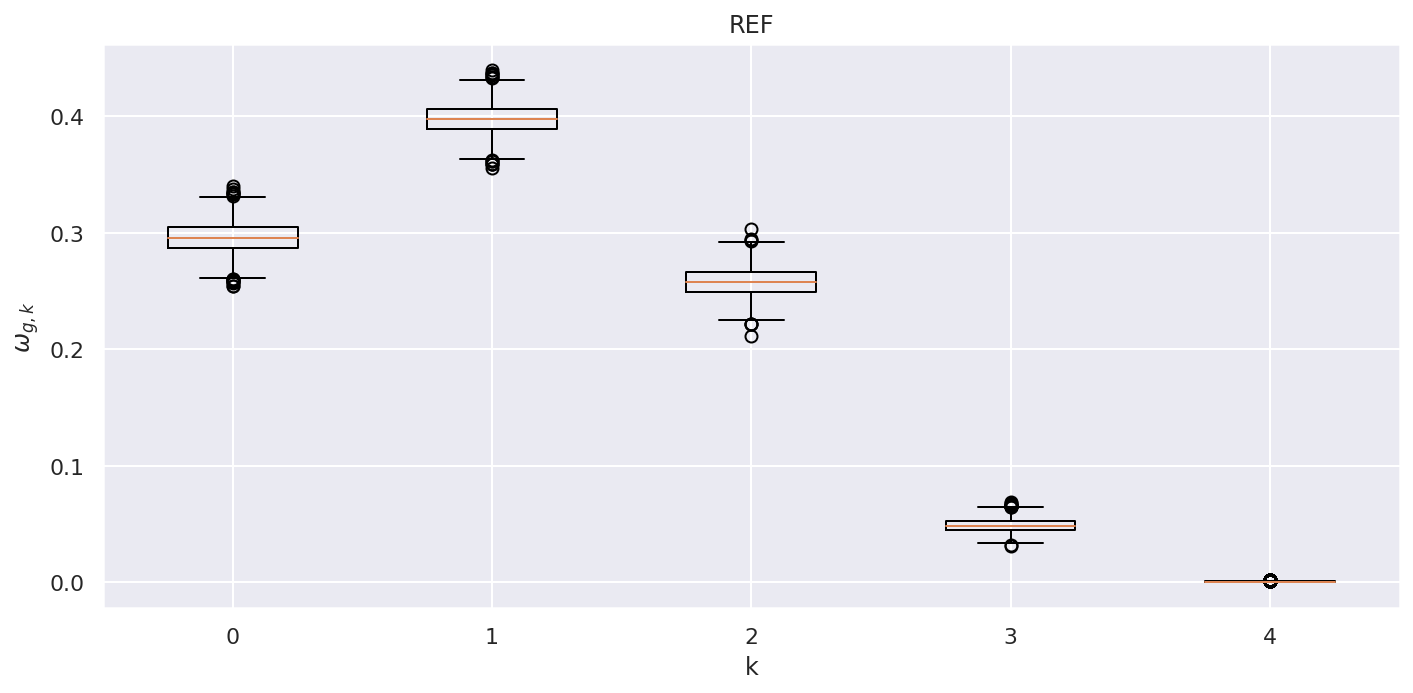

In [ ]:
fig, ax = plt.subplots(1, model.G, sharex=True, sharey=True, figsize=(10, 5))
if model.G == 1:
    ax = [ax]    
for g in range(model.G):
    if model.G > 1:
        w = posterior_samples['omega'][:,g,:].transpose()
    else:
        w = posterior_samples['omega'].transpose()
    _ = ax[g].boxplot(w)
    _ = ax[g].set_xticklabels(np.arange(model.T))
    _ = ax[g].set_title(model.group_names[g])
    _ = ax[g].set_xlabel('k')
    _ = ax[g].set_ylabel(r'$\omega_{g,k}$')
fig.tight_layout(h_pad=2, w_pad=2)

In [ ]:
if model.G > 1:
    kls = []
    for g in range(model.G):
        p = posterior_samples['omega'][:,0,:]
        q = posterior_samples['omega'][:,g,:]
        kls.append((p * (np.log(p) - np.log(q))).sum(-1))

    _ = plt.boxplot(kls[1:])
    _ = plt.ylabel(r'$E[KL(\omega_0||\omega_g)]$')
    _ = plt.xticks(np.arange(model.G - 1) + 1, model.group_names[1:]) 

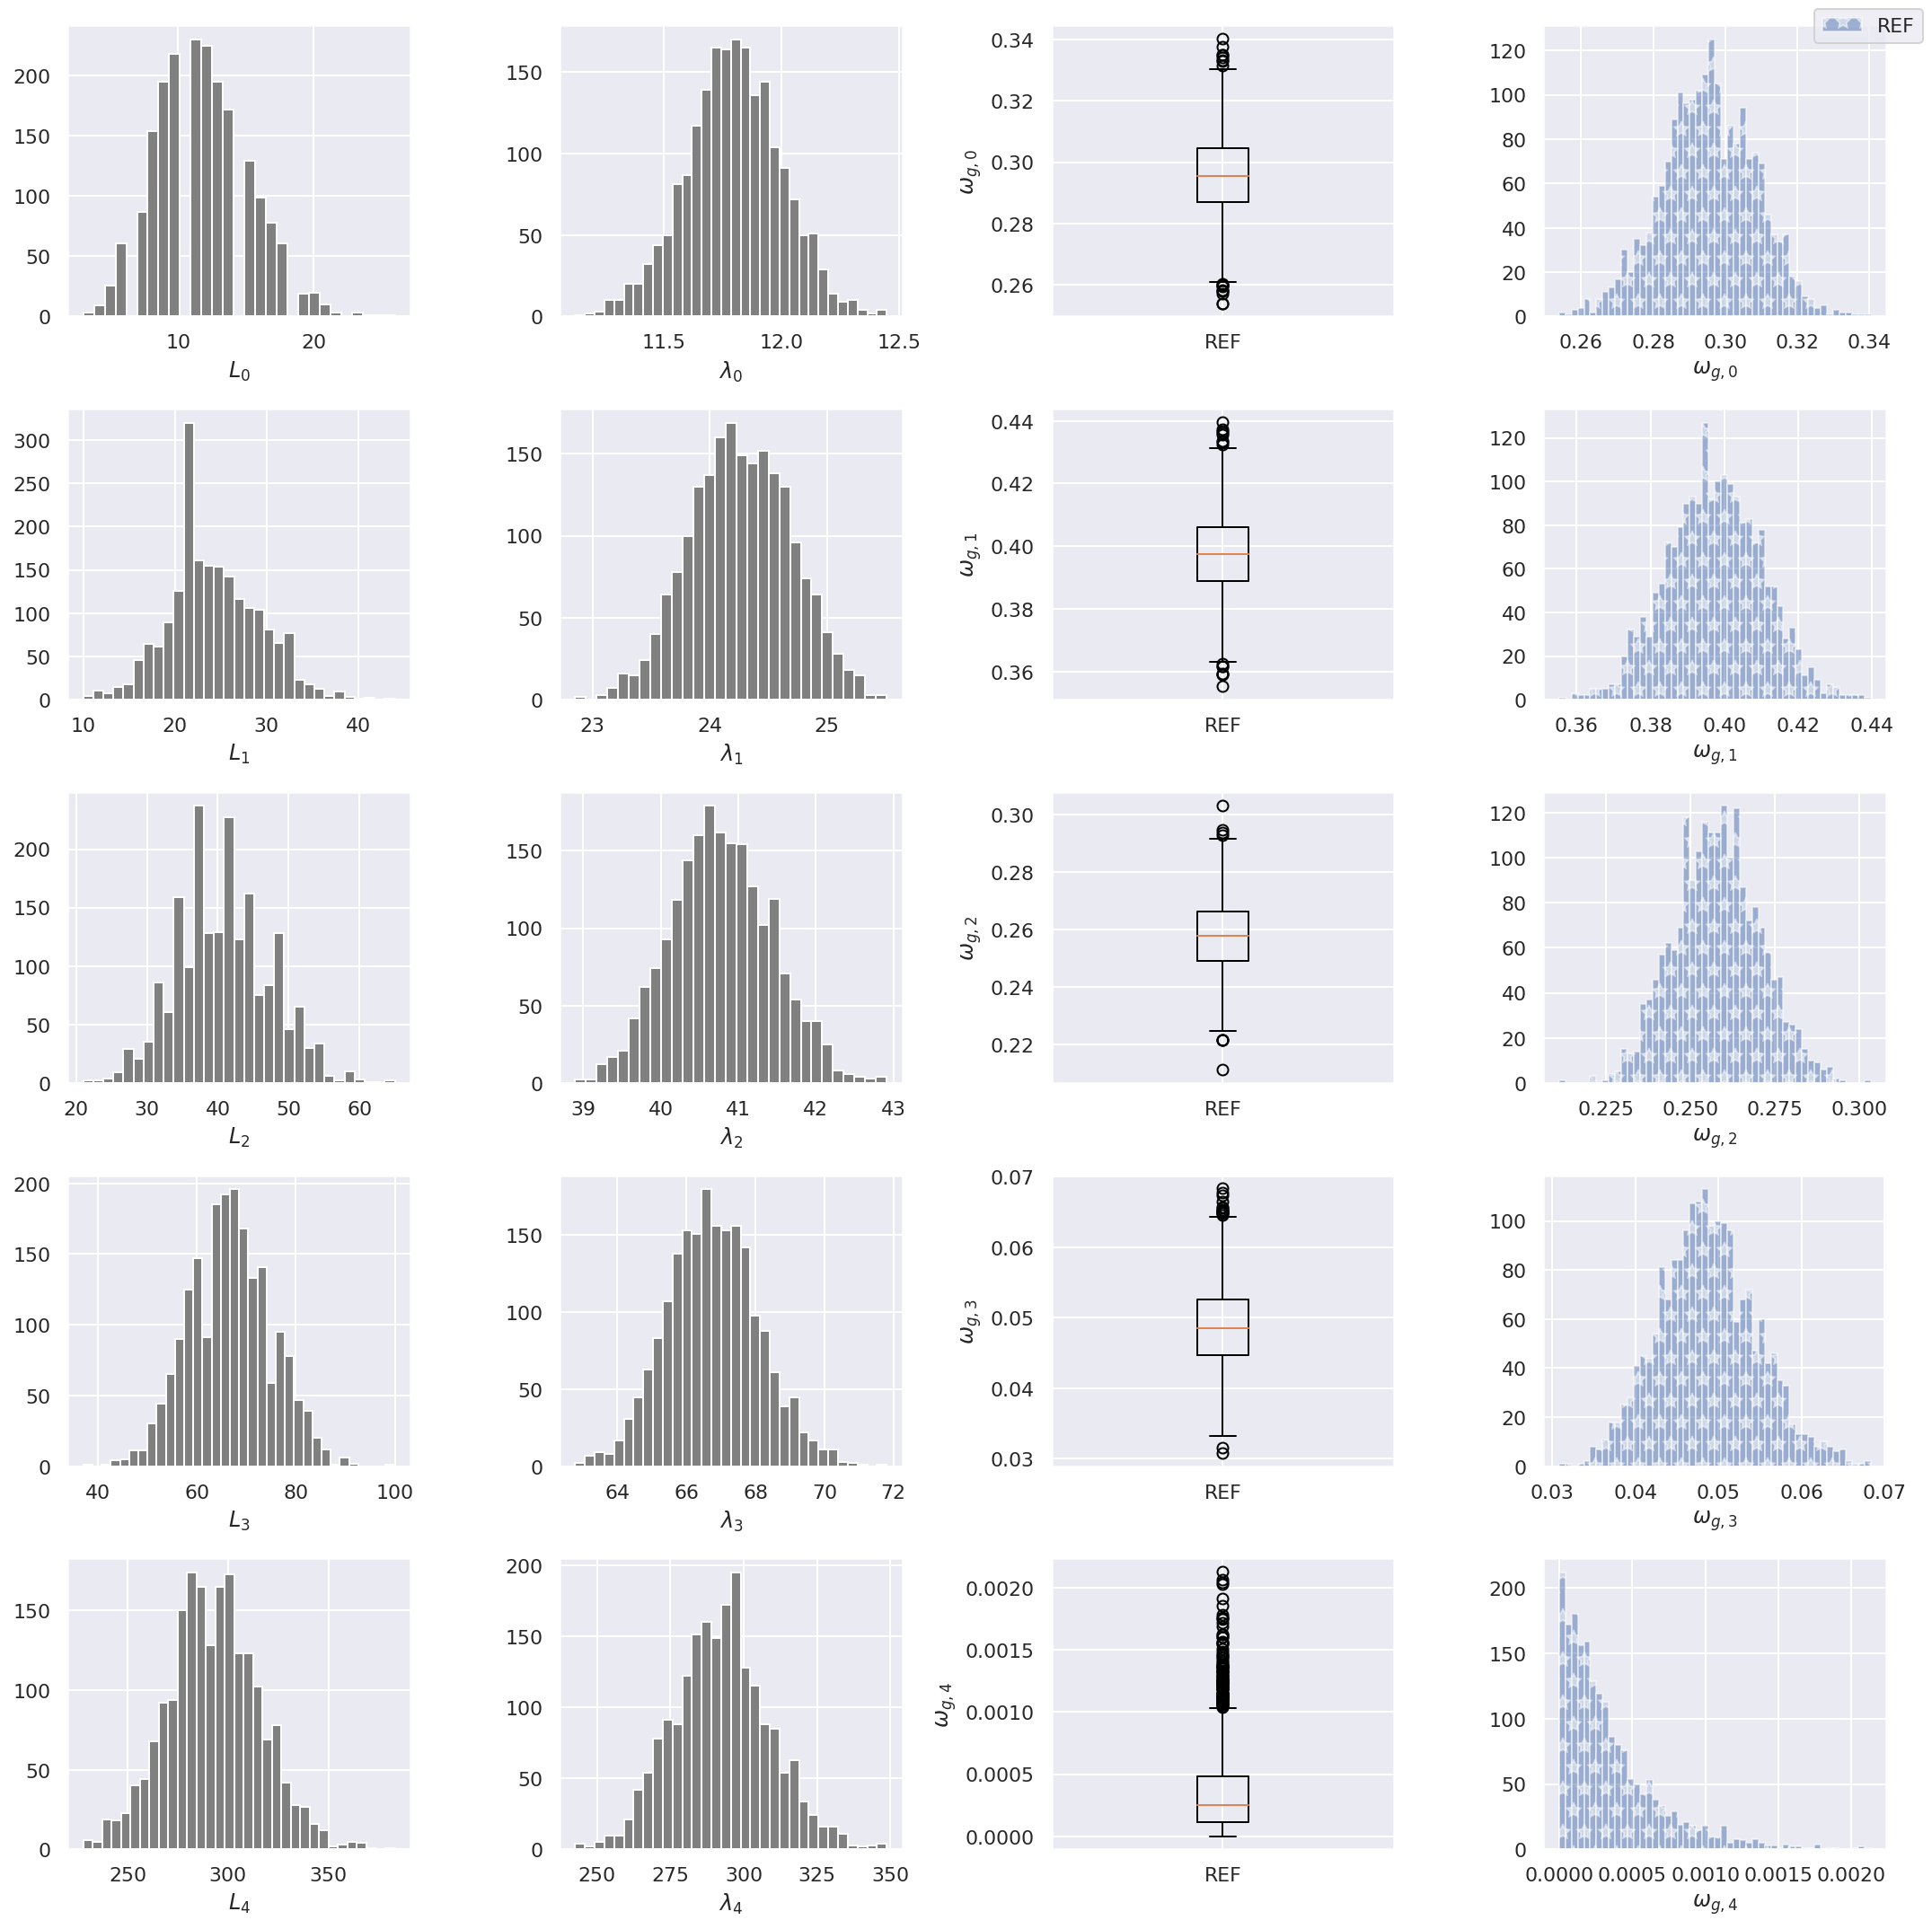

In [ ]:
hatches = ['*', 'o', '/', '-']
fig, ax = plt.subplots(model.T, 4, figsize=(15, 15))

for t in range(model.T):
    _ = ax[t, 0].hist(np.random.poisson(model.posterior_samples['rate'][:, t]), color='gray', bins='auto')
    _ = ax[t, 0].set_xlabel(r'$L_{%d}$' % t)
    
    _ = ax[t, 1].hist(model.posterior_samples['rate'][:, t], color='gray', bins='auto')
    _ = ax[t, 1].set_xlabel(r'$\lambda_{%d}$' % t)

    if model.G > 1:
        _ = ax[t, 2].boxplot([model.posterior_samples['omega'][:,g,t].transpose() for g in range(model.G)])
    else:
        _ = ax[t, 2].boxplot(model.posterior_samples['omega'][:,t].transpose())

    _ = ax[t, 2].set_xticklabels(model.group_names)
    _ = ax[t, 2].set_ylabel(r'$\omega_{g,%d}$' % t)    
    pal = cycle(sns.color_palette())
    if model.G > 1:
        for g in range(model.G):
            _ = ax[t, 3].hist(model.posterior_samples['omega'][:,g,t], alpha=0.5, color=next(pal), hatch=hatches[g], bins=50, label=model.group_names[g] if t==0 else None)        
    else:
        _ = ax[t, 3].hist(model.posterior_samples['omega'][:,t], alpha=0.5, color=next(pal), hatch=hatches[0], bins=50, label=model.group_names[0] if t==0 else None)        
    _ = ax[t, 3].set_xlabel(r'$\omega_{g,%d}$' % t)
    
fig.legend()
fig.tight_layout(h_pad=1, w_pad=1)